In [19]:
# reading images from the file
# visualize the data 

import pandas as pd 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2

%matplotlib inline 


#reading the cvs file and extract the data 
data_dir = './data'
data_csv = '/driving_log.csv'

file_path = data_dir+data_csv

#image_path = pd.read_csv(data_dir+data_csv)
#print(image_path.head())

#train = image_path[['center','left','right','steering']]

#print(X_train.head())
#print(train.shape)

#print(train.iloc[0])
#print()
#print(train.iloc[0].left)

#print (train.as_matrix()[0][1])
#img_p = train.iloc[0].left.strip()

#img = plt.imread(data_dir+'/'+img_p)

#print(img.dtype)
#plt.imshow(img)

#train and test split 

#X_train, X_valid = train_test_split(train, test_size=0.2, random_state=42)

#print(X_train.shape)
#print(X_valid.shape)
#print(X_train.head())

#loading the cvs files into the 
def data_load(file_path):
    image_path = pd.read_csv(file_path)
    train = image_path[['center','left','right','steering']]
    data_train, data_valid = train_test_split(train,test_size=0.1, random_state=42)
    return data_train, data_valid

#get data(img, steering) from one of the cameras
def get_img_steering(row, camera_num, steering_offset=0.2):
    if camera_num ==0: 
        img_path = row.left.strip()
        steering = row.steering + steering_offset
    elif camera_num ==1:
        img_path = row.center.strip()
        steering = row.steering
    else:
        img_path = row.right.strip()
        steering = row.steering - steering_offset
    
    image = plt.imread(data_dir+'/'+img_path)
    #plt.imshow(image)
    return image, steering 

#flip the image randomly 
def random_flip(image, steering):
    r = np.random.randint(2)
    if r ==1:
        return np.fliplr(image), -steering
    else:
        return image, steering
    
#randomly choose the camera from a certain row 
def random_camera(row):
    r = np.random.randint(3)
    return get_img_steering(row, r)


#generator for validation 
def train_generator(data_train, BATCH_SIZE):
    num_samples = len(data_train)
    while 1: 
        shuffle(data_train)
        images =[]
        steerings =[]
        for i in range(BATCH_SIZE):
            row = data_train.iloc[i]
            image, steering = random_camera(row)
            image, steering = random_flip(image, steering)
            image = cv2.resize(image, (64,64), cv2.INTER_AREA)
            images.append(image)
            steerings.append(steering)
            #print(len(images))
            #print (steerings)
            
        yield np.array(images),np.array(steerings)



In [20]:
# train, and valid data prepared 
BATCH_SIZE = 128 

data_train, data_valid = data_load(file_path)
X_train = train_generator(data_train, BATCH_SIZE)
#for i in range(4):
#    img, steer = next(X_train)
#    print(img.shape)
#   # print(steer)
#img, steering = random_camera(data_train.iloc[0])
#plt.subplot(1,2,1)
#plt.imshow(img)
#img,steering = random_flip(img, steering)
#plt.subplot(1,2,2)
#plt.imshow(img)

X_valid = train_generator(data_valid, BATCH_SIZE)

In [21]:
#debug
#print(len(data_train))
#print(len(data_valid))

In [22]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Lambda
from keras.layers import Cropping2D
import cv2

#nvidia architecture
model = Sequential()

#crop the images input image 3,160,320
#model.add(Cropping2D(cropping=((50,20),(0,0)),input_shape=(64,64,3)))

#normalize the image data 3,160,320
model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(64,64,3)))

#convolutional network 24,31,98  kernel 5x5 
model.add(Convolution2D(24,5,5, border_mode='valid', subsample=(2,2),activation='relu'))

#convolutional network 36,14,47 kernel 5x5
model.add(Convolution2D(36,5,5, border_mode='valid', subsample=(2,2),activation='relu'))

#convolutional network 48,5,22 kernel 3x3
model.add(Convolution2D(48,3,3, border_mode='valid', subsample=(2,2),activation='relu'))

#convolutional network 64,3,20 kernel 3x3
model.add(Convolution2D(64,3,3, border_mode='valid',subsample=(1,1),activation='relu'))

#convolutional network 64,1,18 kernel 3x3
#model.add(Convolution2D(64,3,3, border_mode='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
#flatten
model.add(Flatten())

#dropout 
model.add(Dropout(0.8))

#fully connected 1164
model.add(Dense(1164))

#fully connected 100
model.add(Dense(100))

#fully connected 50
model.add(Dense(50))

#fully connected 10
model.add(Dense(10))

#final ouput 
model.add(Dense(1))


Epoch 1/5
7168/7232 [============================>.] - ETA: 0s - loss: 0.0650

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


7296/7232 [==============================] - 16s - loss: 0.0644 - val_loss: 0.0307
Epoch 2/5
7296/7232 [==============================] - 14s - loss: 0.0283 - val_loss: 0.0275
Epoch 3/5
7296/7232 [==============================] - 14s - loss: 0.0245 - val_loss: 0.0253
Epoch 4/5
7296/7232 [==============================] - 15s - loss: 0.0205 - val_loss: 0.0220
Epoch 5/5
7296/7232 [==============================] - 14s - loss: 0.0174 - val_loss: 0.0202
dict_keys(['val_loss', 'loss'])


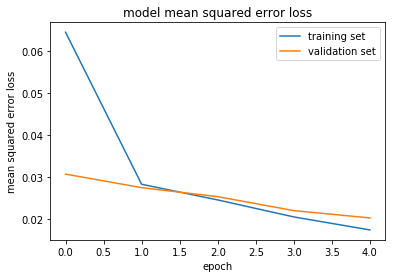

In [23]:
# run the model , generator data  X_train,  X_valid
EPOCH = 5


model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(X_train, samples_per_epoch = len(data_train),
                                    validation_data = X_valid,
                                    nb_val_samples=len(data_valid),
                                    nb_epoch=EPOCH, 
                                    verbose =1)

model.save('model.h5')
json_string = model.to_json()
open('my_model_architecture.json', 'w').write(json_string)

print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper right')
plt.show()

